# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, decimate
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  4000


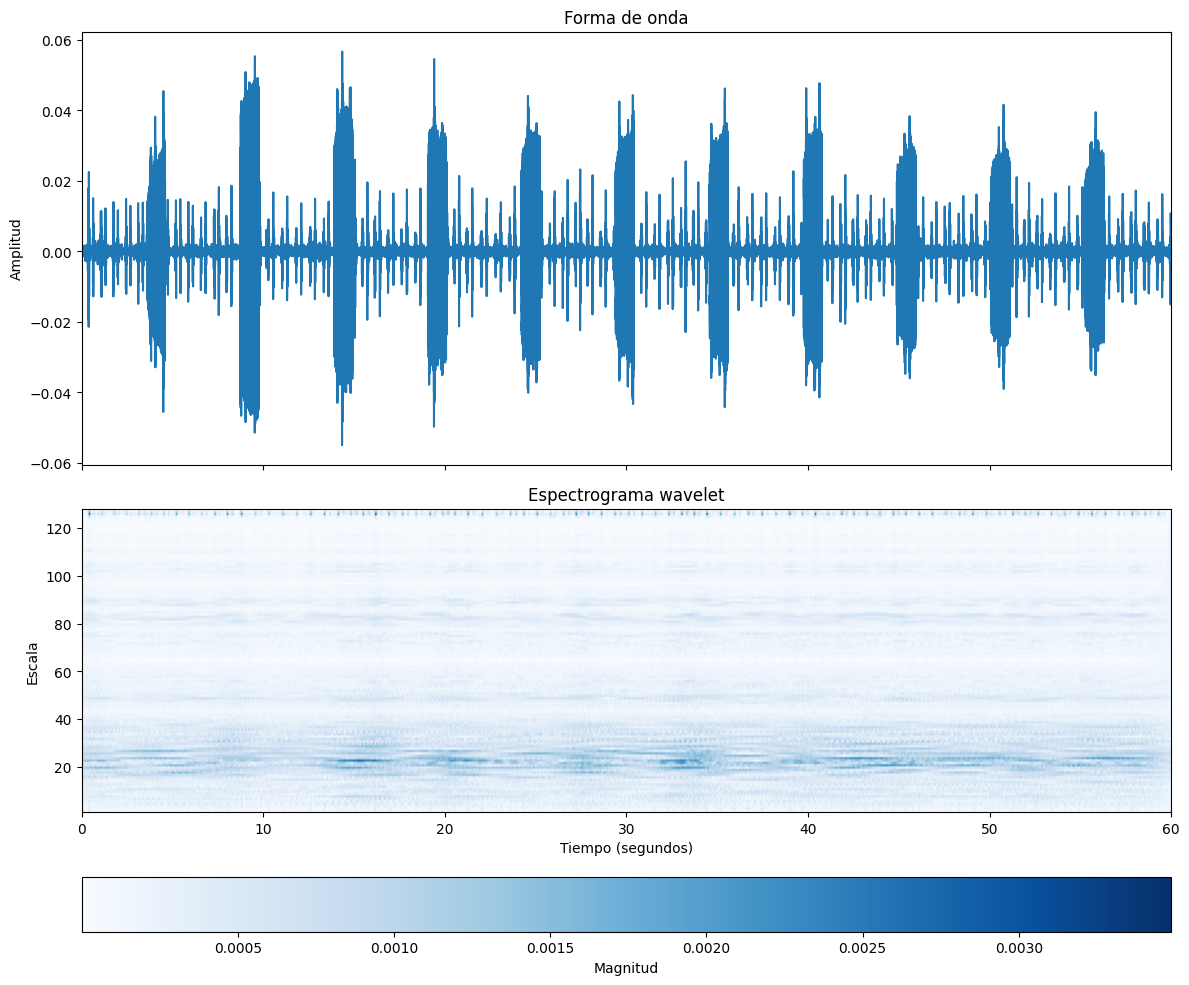

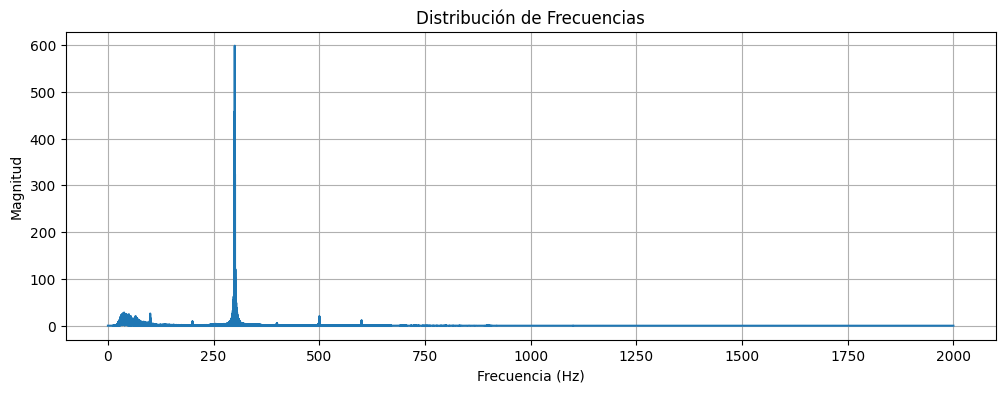

In [2]:
AUDIO_NAME = "Eko_Recording_Sound_Export_08_17_2024_2_57_PM.wav"
audio_dir = get_base_dir().joinpath("data", "digital", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

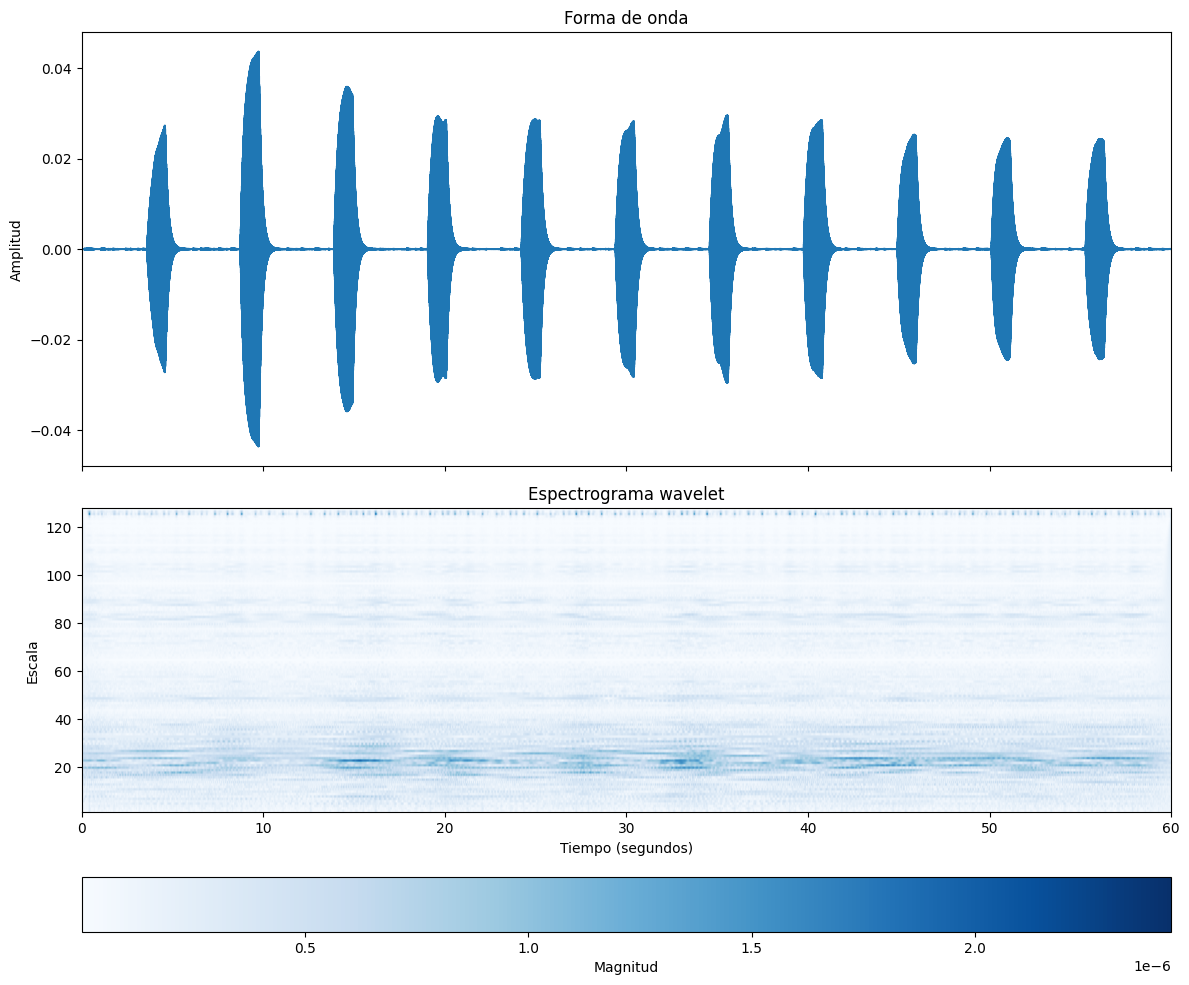

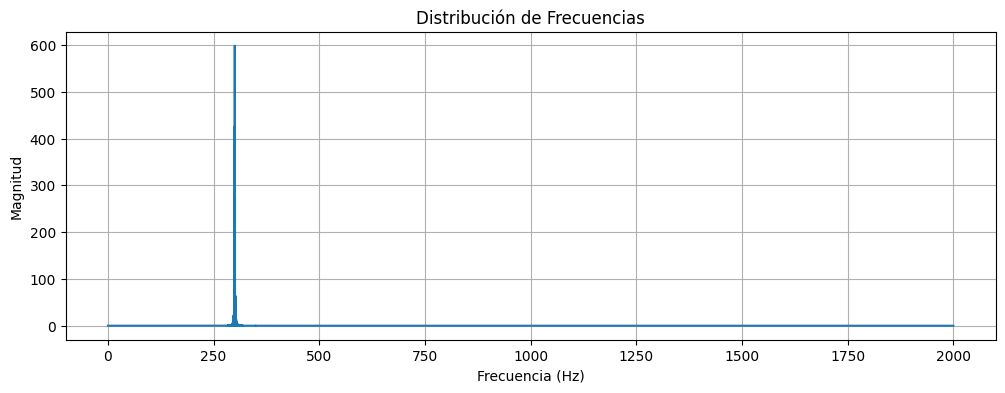

In [3]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    audio, sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Absolute signal

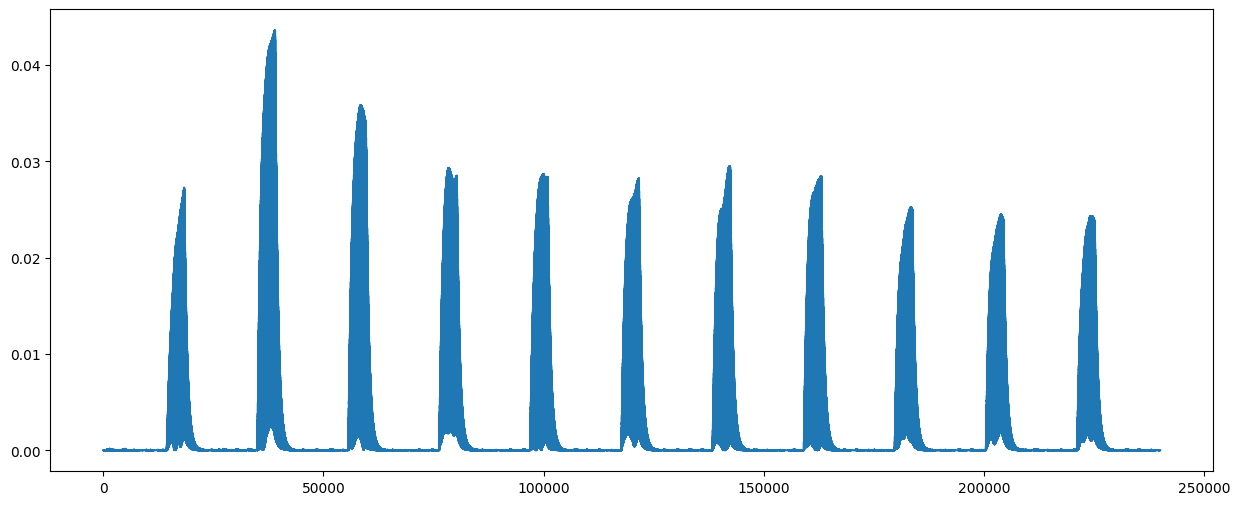

In [4]:
abs_filtered = filtered_audio.abs()

plt.figure(figsize=(15, 6))
plt.plot(abs_filtered.squeeze())

# Downsample it

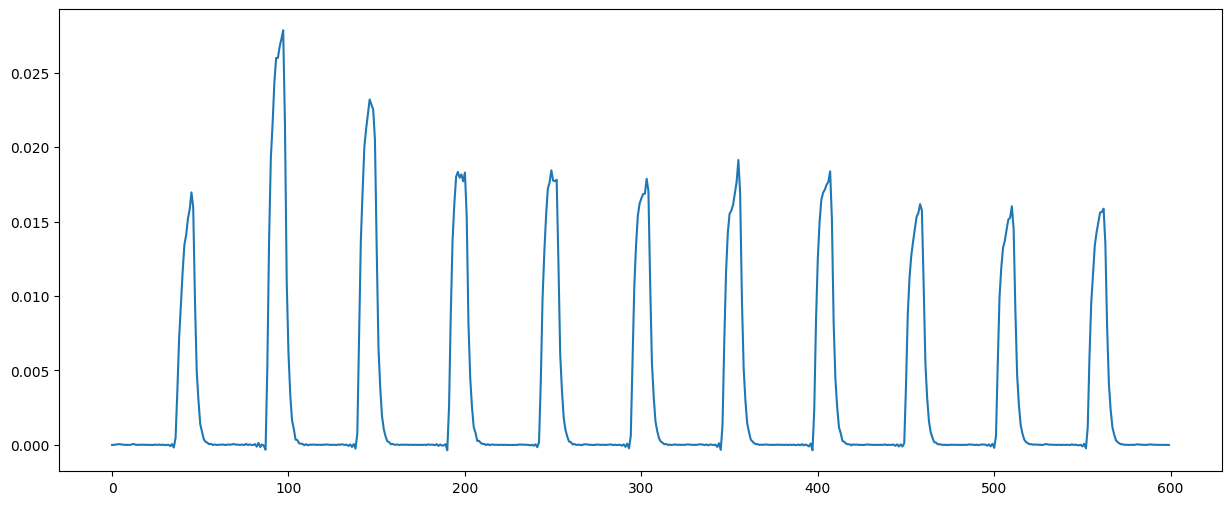

In [5]:
DOWNSAMPLE_FACTOR = 400

downsampled = decimate(abs_filtered, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

# Smooth it

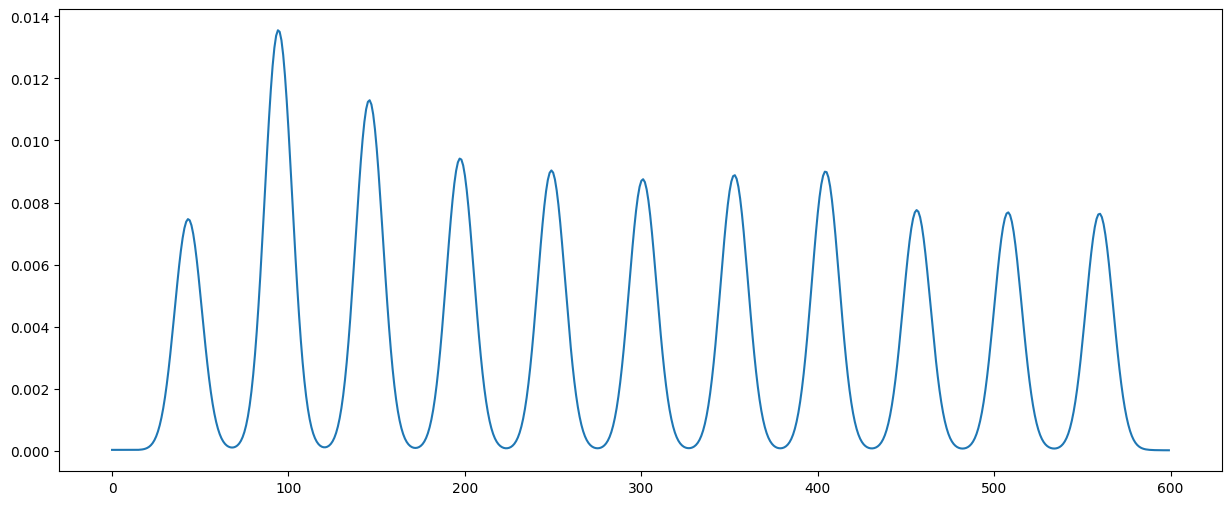

In [6]:
SIGMA_SMOOTH = 7

smoothed = gaussian_filter1d(downsampled, sigma=SIGMA_SMOOTH)

plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

# Find peaks where signal changes

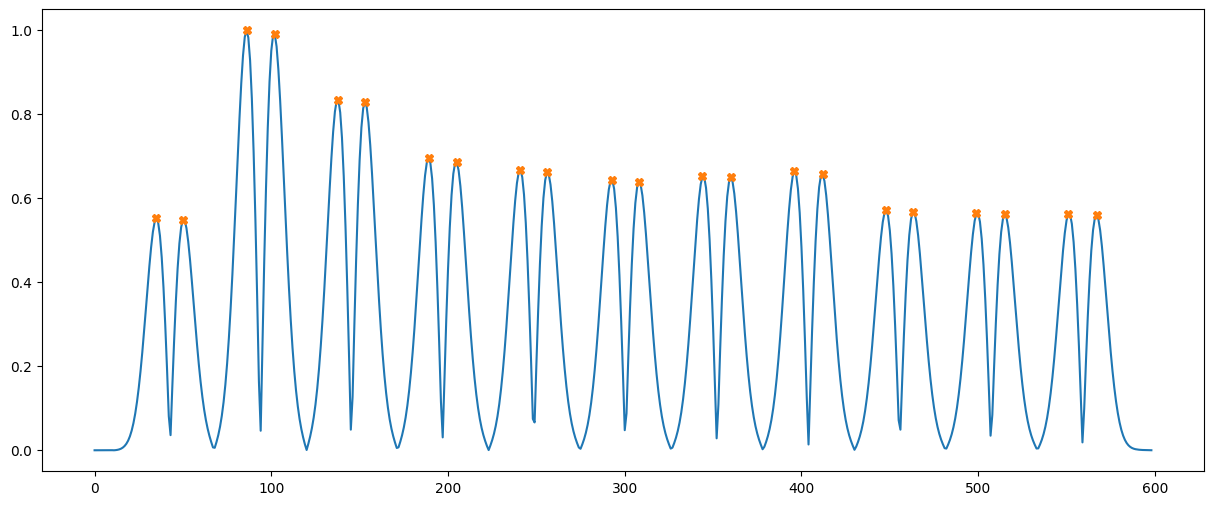

In [7]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 35  50  86 102 138 153 189 205 241 256 293 308 344 360 396 412 448 463
 499 515 551 567]
Peaks in real signal: [ 14000  20000  34400  40800  55200  61200  75600  82000  96400 102400
 117200 123200 137600 144000 158400 164800 179200 185200 199600 206000
 220400 226800]


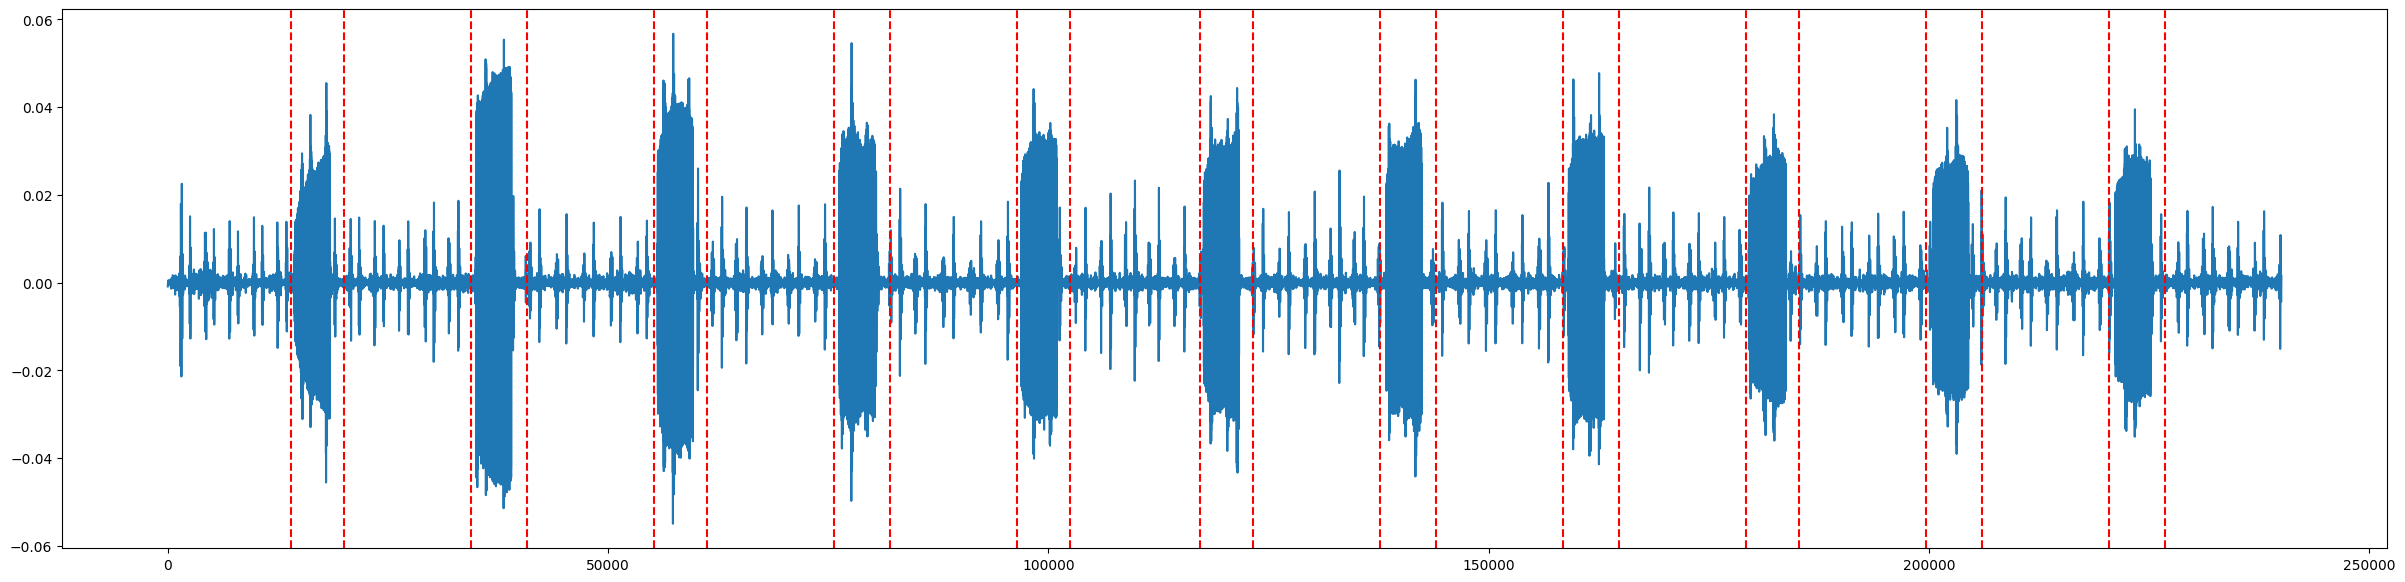

In [8]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.show()

# Split signal

In [9]:
split_points = np.concatenate(([0], upsampled_peaks, [audio.shape[1]]))

audio_tensor = audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / sample_rate
    to_print = f"#{i+1} ({duration:.2f}s)"

    if duration < 2:
        to_print += " trigger"
    else:
        to_print += " segment"

    # to_print += f": {segment}"
    print(to_print)

#1 (3.50s) segment
#2 (1.50s) trigger
#3 (3.60s) segment
#4 (1.60s) trigger
#5 (3.60s) segment
#6 (1.50s) trigger
#7 (3.60s) segment
#8 (1.60s) trigger
#9 (3.60s) segment
#10 (1.50s) trigger
#11 (3.70s) segment
#12 (1.50s) trigger
#13 (3.60s) segment
#14 (1.60s) trigger
#15 (3.60s) segment
#16 (1.60s) trigger
#17 (3.60s) segment
#18 (1.50s) trigger
#19 (3.60s) segment
#20 (1.60s) trigger
#21 (3.60s) segment
#22 (1.60s) trigger
#23 (3.30s) segment


# Keep just the valid segments

#1 (3.5s): tensor([-8.5449e-04, -8.2397e-04, -7.6294e-04,  ...,  4.2725e-04,
         2.4414e-04,  9.1553e-05])


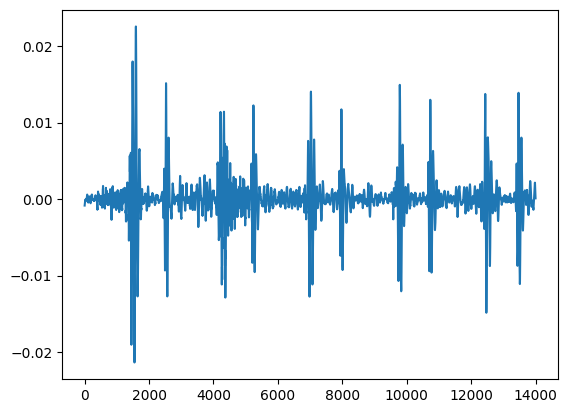

#2 (3.6s): tensor([ 0.0006,  0.0006,  0.0006,  ..., -0.0004, -0.0004, -0.0004])


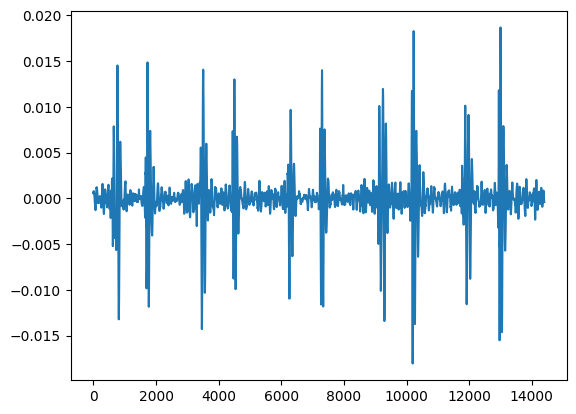

#3 (3.6s): tensor([-0.0005, -0.0006, -0.0008,  ..., -0.0007, -0.0008, -0.0009])


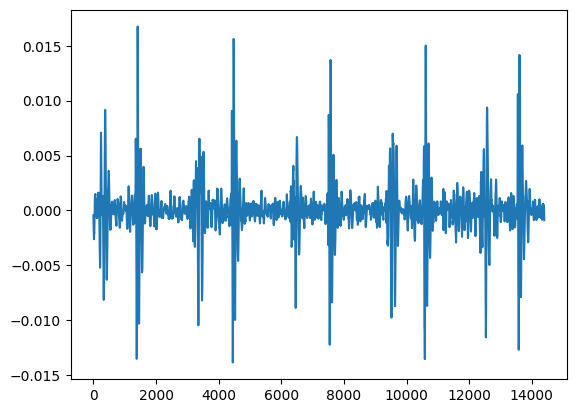

#4 (3.6s): tensor([-2.7466e-04, -2.7466e-04, -2.4414e-04,  ...,  0.0000e+00,
        -6.1035e-05, -1.8311e-04])


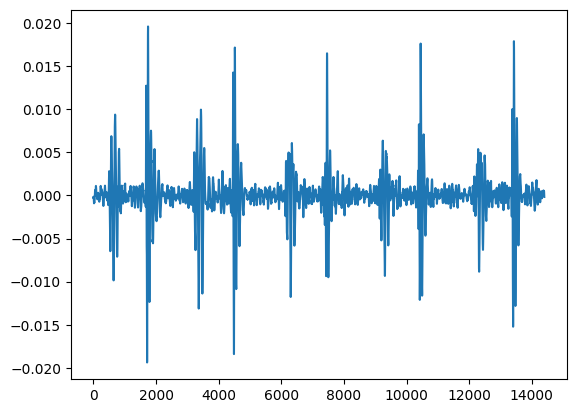

#5 (3.6s): tensor([ 2.1362e-04, -3.0518e-05, -3.6621e-04,  ...,  1.2207e-04,
         1.8311e-04,  2.4414e-04])


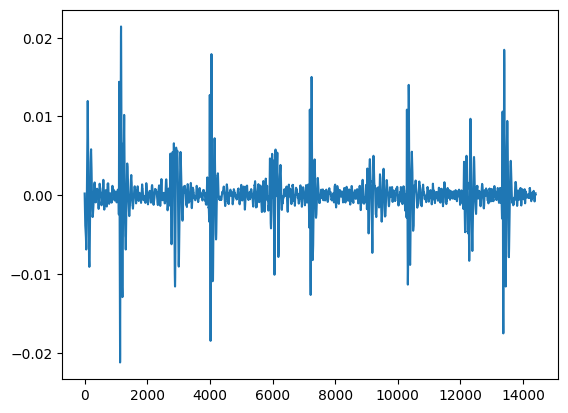

#6 (3.7s): tensor([1.5259e-04, 9.1553e-05, 6.1035e-05,  ..., 3.0518e-05, 5.1880e-04,
        1.0071e-03])


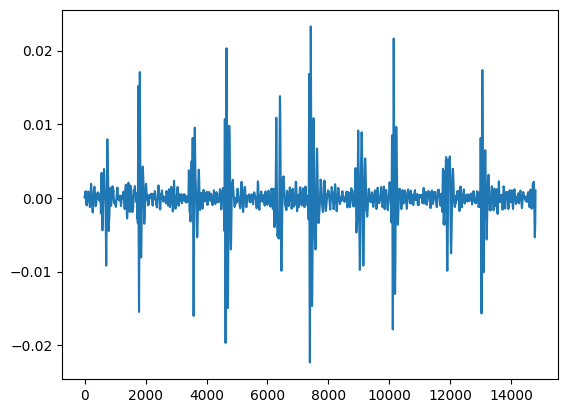

#7 (3.6s): tensor([0.0041, 0.0044, 0.0045,  ..., 0.0077, 0.0076, 0.0075])


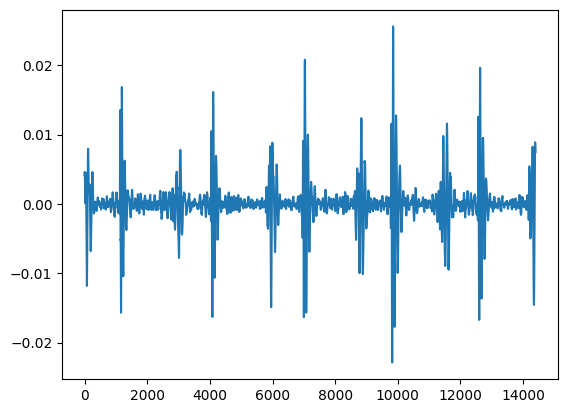

#8 (3.6s): tensor([-0.0007, -0.0008, -0.0008,  ..., -0.0012, -0.0013, -0.0014])


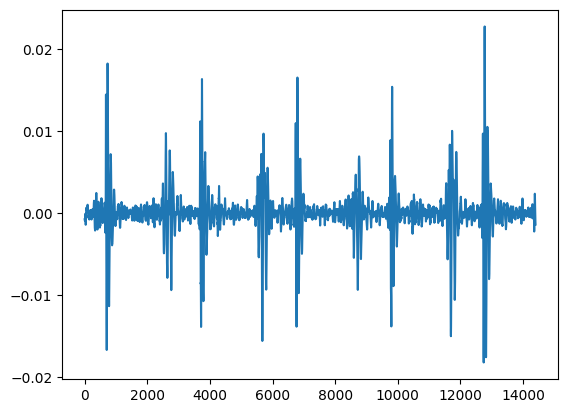

#9 (3.6s): tensor([ 0.0004,  0.0005,  0.0007,  ..., -0.0002, -0.0002, -0.0002])


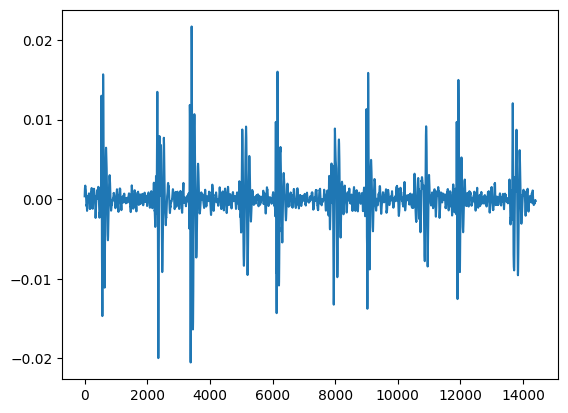

#10 (3.6s): tensor([0.0018, 0.0017, 0.0016,  ..., 0.0013, 0.0013, 0.0012])


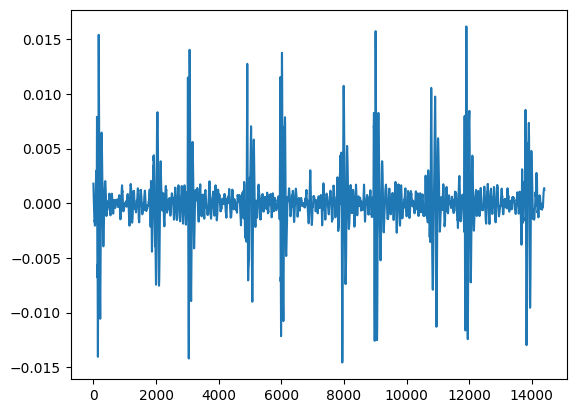

#11 (3.6s): tensor([-0.0137, -0.0138, -0.0139,  ..., -0.0018, -0.0020, -0.0022])


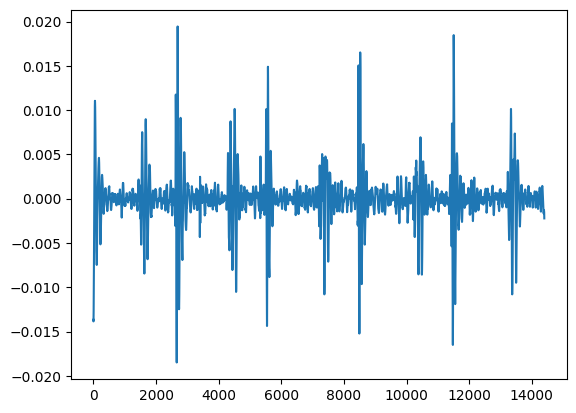

#12 (3.3s): tensor([-0.0005, -0.0003, -0.0002,  ...,  0.0012,  0.0013,  0.0015])


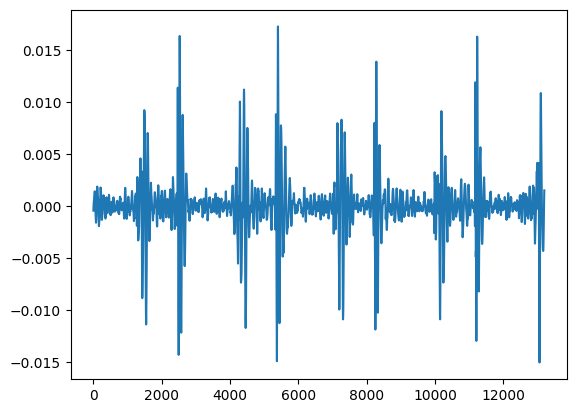

In [10]:
MIN_SECS = 3

filtered_segments = filter(lambda x: len(x) / sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

#1 (3.5s): tensor([0.4670, 0.4677, 0.4691,  ..., 0.4962, 0.4920, 0.4885])


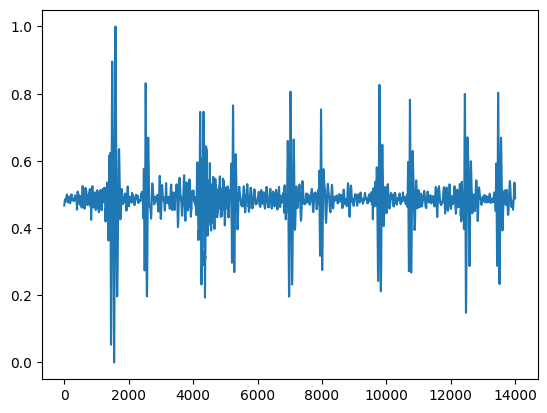

#2 (3.6s): tensor([0.5079, 0.5079, 0.5071,  ..., 0.4813, 0.4813, 0.4805])


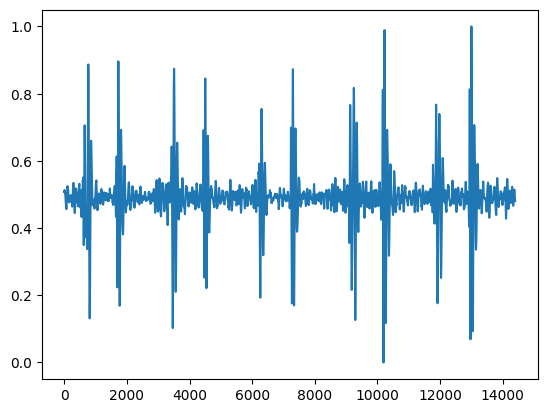

#3 (3.6s): tensor([0.4377, 0.4327, 0.4277,  ..., 0.4287, 0.4257, 0.4237])


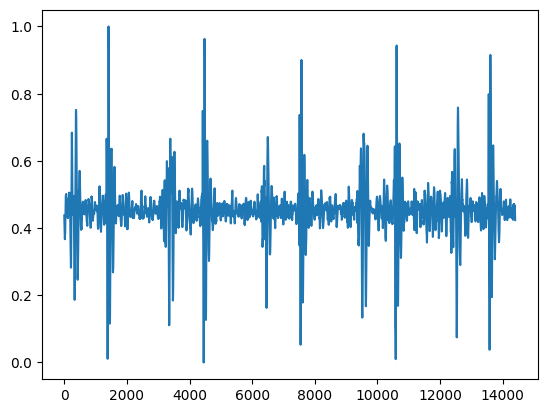

#4 (3.6s): tensor([0.4902, 0.4902, 0.4910,  ..., 0.4973, 0.4957, 0.4926])


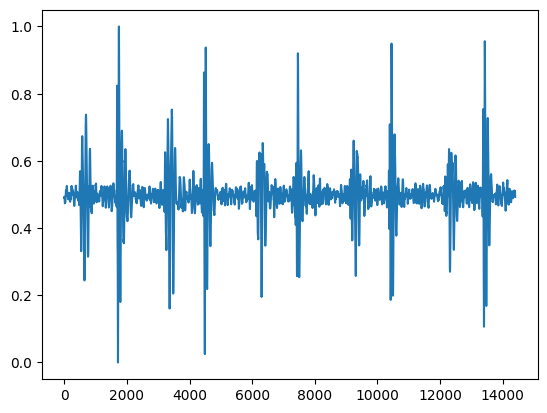

#5 (3.6s): tensor([0.5029, 0.4971, 0.4893,  ..., 0.5007, 0.5021, 0.5036])


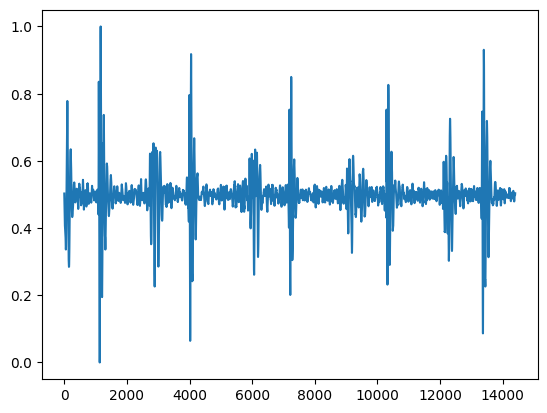

#6 (3.7s): tensor([0.4930, 0.4916, 0.4910,  ..., 0.4903, 0.5010, 0.5117])


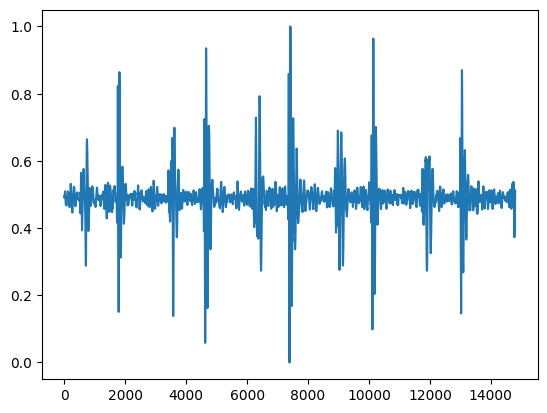

#7 (3.6s): tensor([0.5570, 0.5627, 0.5658,  ..., 0.6314, 0.6282, 0.6263])


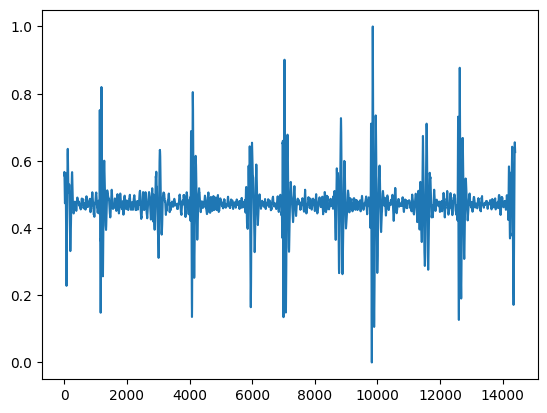

#8 (3.6s): tensor([0.4262, 0.4255, 0.4255,  ..., 0.4151, 0.4128, 0.4106])


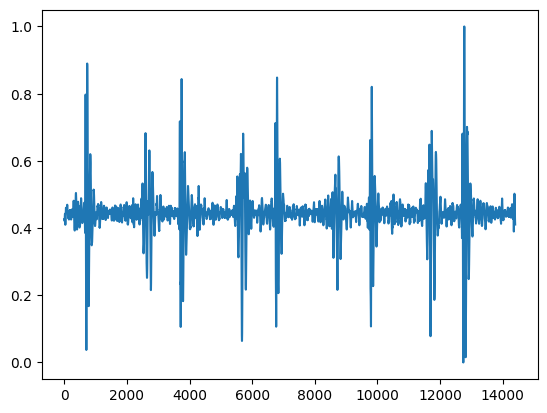

#9 (3.6s): tensor([0.4946, 0.4989, 0.5025,  ..., 0.4808, 0.4808, 0.4801])


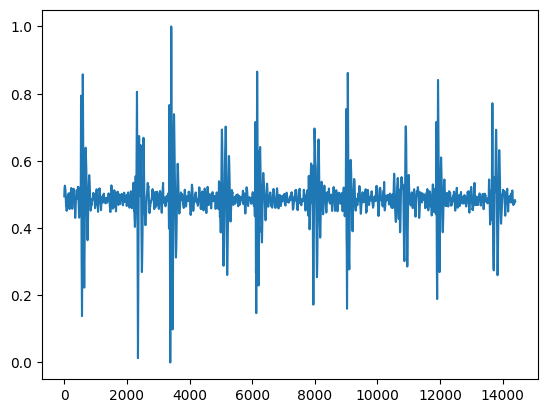

#10 (3.6s): tensor([0.5323, 0.5293, 0.5263,  ..., 0.5164, 0.5144, 0.5134])


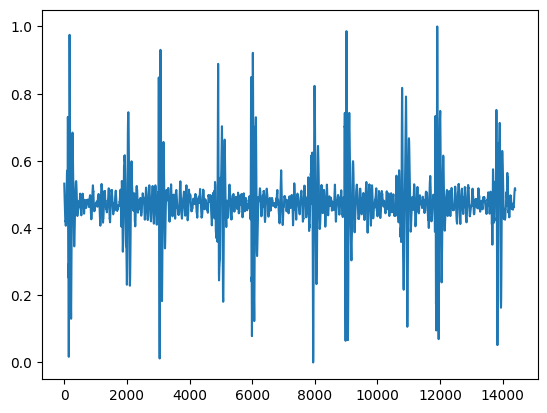

#11 (3.6s): tensor([0.1271, 0.1239, 0.1223,  ..., 0.4401, 0.4344, 0.4288])


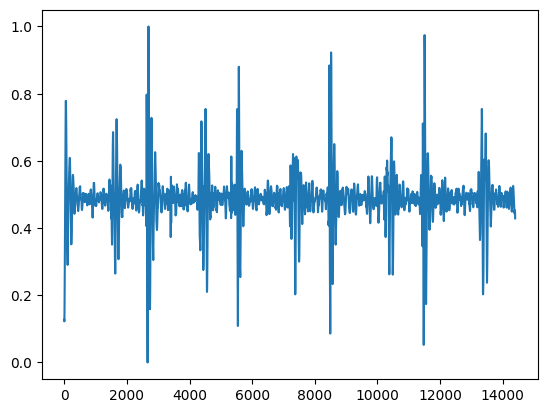

#12 (3.3s): tensor([0.4519, 0.4557, 0.4585,  ..., 0.5028, 0.5075, 0.5123])


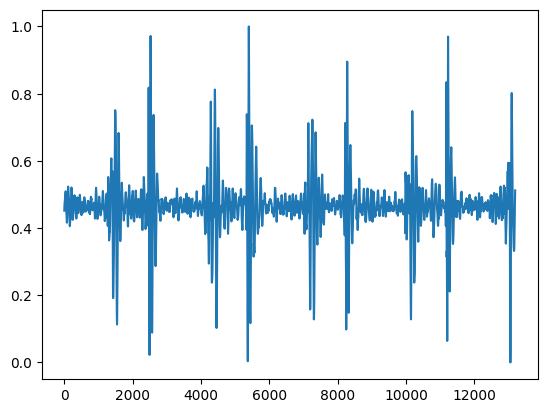

In [11]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=audio_dir,
    sample_rate_target=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()